In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ['COBAYA_NOMPI'] = 'True'
#
from cobaya.yaml          import yaml_load_file
from cobaya.samplers.mcmc import plot_progress
from cobaya.model         import get_model
#
from   getdist.mcsamples  import MCSamplesFromCobaya
from   getdist.mcsamples  import loadMCSamples
import getdist.plots      as     gdplt
#
base='/global/cscratch1/sd/mwhite/BOSS/Cobaya/BOSSxPlanck'
for ndir in ['','emulator','rsd_likelihood','gxk_likelihood']:
    sys.path.append(base+'/'+ndir+'/')
#

In [3]:
#ginfo = yaml_load_file("rxk_boss_bias.yaml")
ginfo = yaml_load_file("rxk_boss_bias_fkp.yaml")
model = get_model(ginfo)

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'stop_on_error']
Loading Taylor series.


array([<AxesSubplot:ylabel='$R-1$'>, <AxesSubplot:ylabel='acc. rate'>],
      dtype=object)

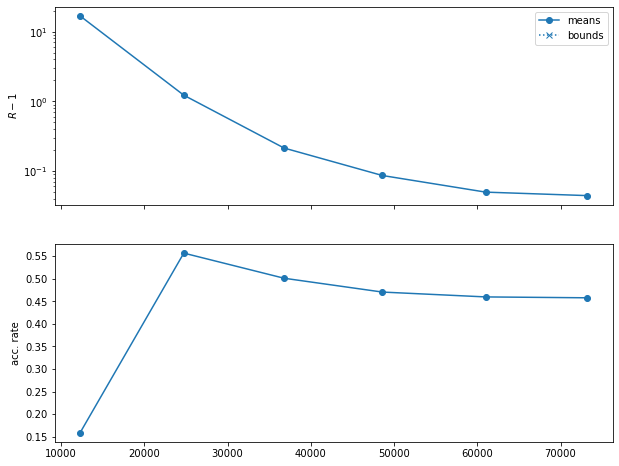

In [4]:
# Now look at chain
plot_progress(ginfo['output'],figure_kwargs={"figsize": (10,8)})

R-1= 0.03979534968008527


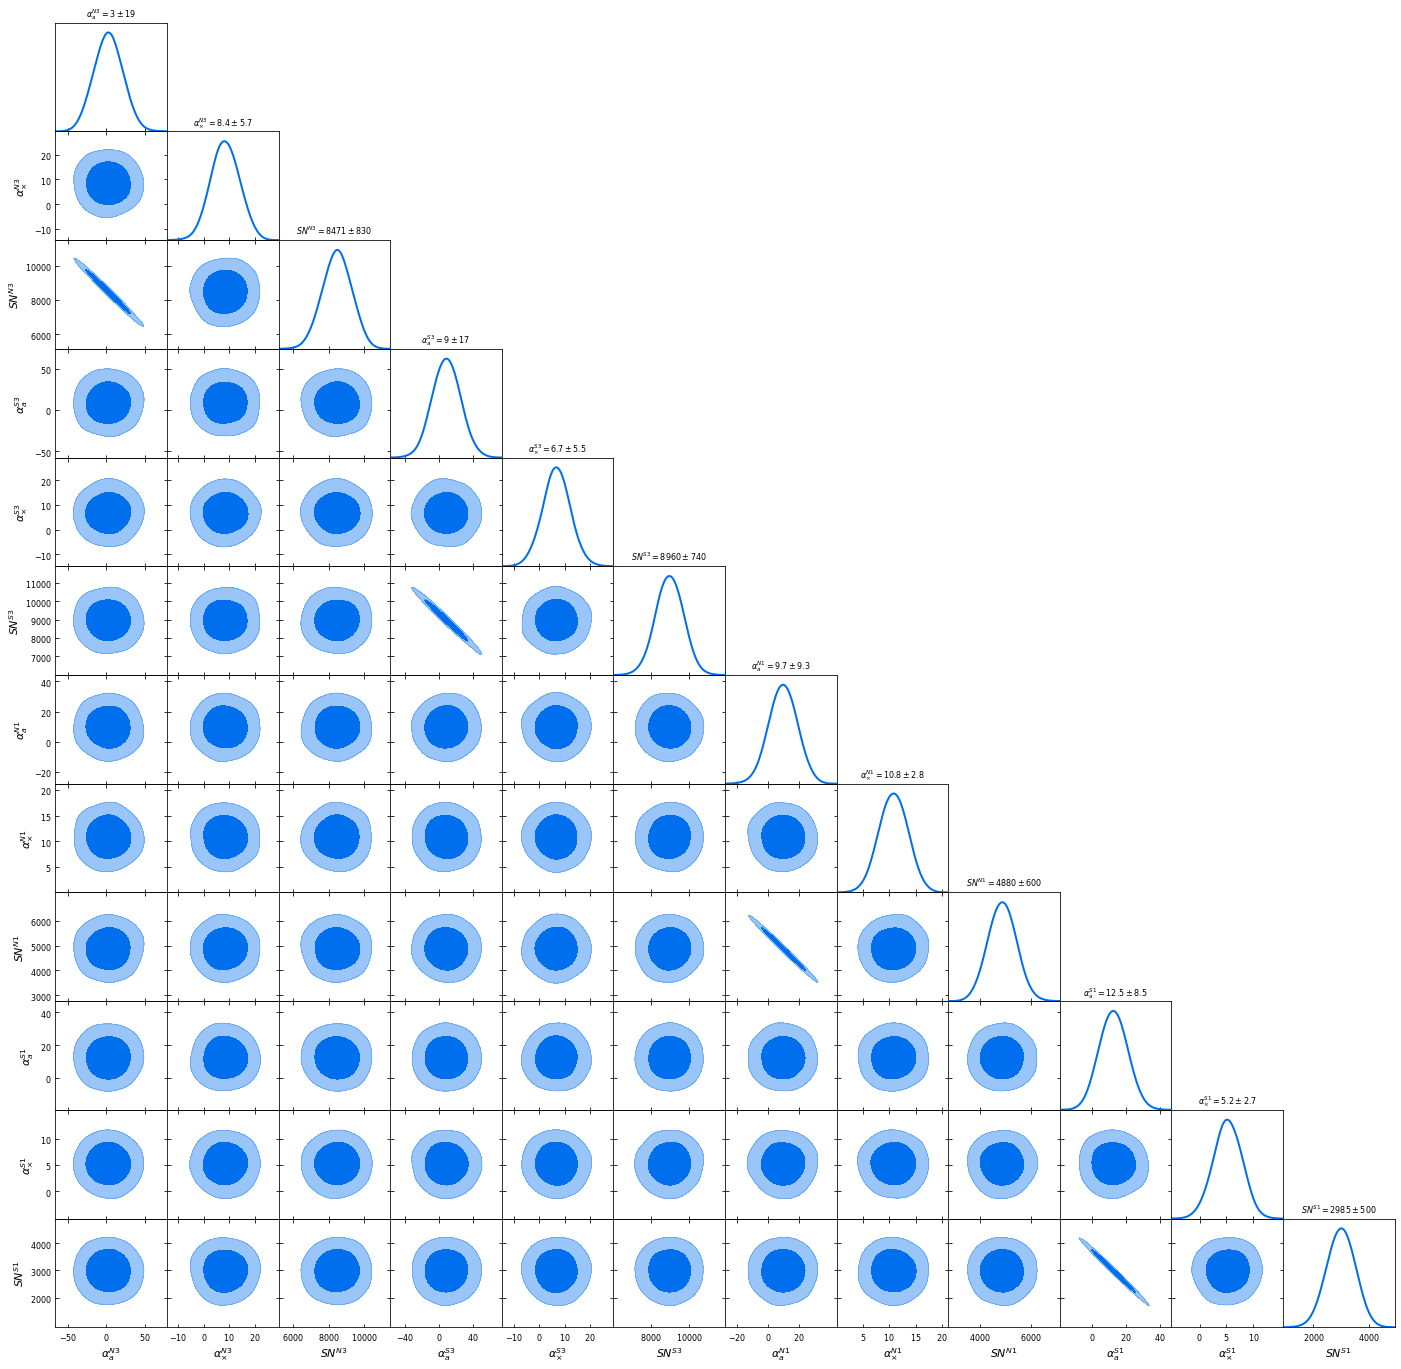

In [5]:
gsamples = loadMCSamples(os.path.abspath(ginfo["output"]),\
                         settings={'ignore_rows':0.5,'contours':[0.68,0.95]},\
                         no_cache=True)
# Analyze and plot
print("R-1=",gsamples.getGelmanRubin())
#
gd = gdplt.get_subplot_plotter()
gd.triangle_plot(gsamples,\
                 ["alpha_a_NGCz3", "alpha_x_NGCz3", "SN_NGCz3",\
                  "alpha_a_SGCz3", "alpha_x_SGCz3", "SN_SGCz3",\
                  "alpha_a_NGCz1", "alpha_x_NGCz1", "SN_NGCz1",\
                  "alpha_a_SGCz1", "alpha_x_SGCz1", "SN_SGCz1"],\
                  filled=True,title_limit=1,contour_lws=2,\
                  figure_kwargs={"figsize": (15,15)})

In [6]:
# Find best fit params
tabs     = gsamples.getParams()
bf       = np.argmin(tabs.chi2)
bf_chi2  = tabs.chi2[bf]
bf_params= {}
print("Best fitting chi^2 is {:f}\n".format(bf_chi2))
#
for param in ginfo['params'].keys():
    # Print the "fixed" parameters for reference.
    if 'value' in ginfo['params'][param]:
        print("{:20s} {:f}".format(param,ginfo['params'][param]['value']))
    # Only add to list if sampled
    if 'ref' in ginfo['params'][param].keys():
        bf_params[param] = getattr(tabs,param)[bf]

Best fitting chi^2 is 115.530720

H0                   69.741410
omegam               0.303377
logA                 2.853178
bsig8_NGCz3          1.676078
b2_NGCz3             -0.278719
bs_NGCz3             2.785463
bsig8_SGCz3          1.655342
b2_SGCz3             -1.524495
bs_SGCz3             -0.941294
bsig8_NGCz1          1.581386
b2_NGCz1             -2.153351
bs_NGCz1             2.192292
bsig8_SGCz1          1.614010
b2_SGCz1             -0.313407
bs_SGCz1             0.203590
bn_NGCz3             0.000000
bn_SGCz3             0.000000
bn_NGCz1             0.000000
bn_SGCz1             0.000000


In [7]:
# Print the best-fitting "sampled" parameters:
bf_params

{'alpha_a_NGCz3': -6.4638956,
 'alpha_x_NGCz3': 7.2765769,
 'SN_NGCz3': 8879.752,
 'smag_NGCz3': 1.1139974,
 'alpha_a_SGCz3': 10.207158999999999,
 'alpha_x_SGCz3': 7.6166208,
 'SN_SGCz3': 8941.1279,
 'smag_SGCz3': 1.0635396000000001,
 'alpha_a_NGCz1': -0.9721554,
 'alpha_x_NGCz1': 11.443848,
 'SN_NGCz1': 5478.3794,
 'smag_NGCz1': 0.77403781,
 'alpha_a_SGCz1': 20.40646,
 'alpha_x_SGCz1': 4.9541685,
 'SN_SGCz1': 2498.4571,
 'smag_SGCz1': 0.7808102}

In [8]:
# Force computation.
model.logposterior(bf_params)

LogPosterior(logpost=-121.73952805800121, logpriors=[-63.97416899032942], loglikes=array([-57.76535907]), derived=[0.7606135211596019])

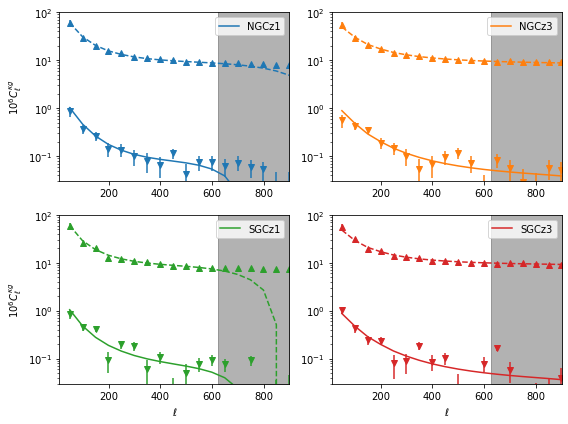

In [9]:
glik = model.likelihood['gxk_likelihood.GxKLikelihood']
#
errs  = np.diag(glik.input_cov)**0.5
iis   = [0, 40, 80, 120]
samps = ['NGCz1','NGCz3','SGCz1','SGCz3']
lmaxs = [600,600,600,600]
#
plt.figure(figsize=(8,6))
#
for n, ii in enumerate(iis):
    plt.subplot(2,2,n+1)
    Cgg_th = glik.obs[ii:ii+20]
    Cgk_th = glik.obs[ii+20:ii+40]
    Cgg    = glik.dd[ii:ii+20]
    Cgk    = glik.dd[ii+20:ii+40]
    errs_gg= errs[ii:ii+20]
    errs_gk= errs[ii+20:ii+40]
    plt.errorbar(glik.xx, 1e6 * Cgg, yerr=1e6*errs_gg, fmt='^', c='C'+str(n))
    plt.plot(glik.xx, 1e6 * Cgg_th, c='C'+str(n), ls = '--')
    plt.errorbar(glik.xx, 1e6 * Cgk, yerr=1e6*errs_gk, fmt='v', c='C'+str(n))
    plt.plot(glik.xx, 1e6 * Cgk_th, c='C'+str(n), label=samps[n])
    plt.fill_between([lmaxs[n]+25,1000],[3e-2,3e-2],[1000, 1000], color='k',alpha=0.3)
    plt.yscale('log')
    plt.ylim(3e-2,100)
    plt.xlim(10,900)
    plt.legend()
    #
    if n == 0 or n == 2:
        plt.ylabel(r'$10^6 C^{\kappa g}_\ell$')
    if n == 2 or n == 3:
        plt.xlabel(r'$\ell$')
plt.tight_layout()

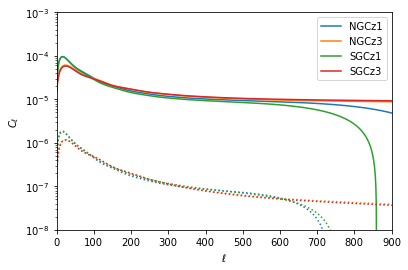

In [10]:
# Plot and save "unwindowed" theory Cells:
for i,samp in enumerate(glik.thy.keys()):  
    thy = glik.thy[samp]
    thy = thy.clip(1e-9,1e30)
    col = 'C'+str(i)
    plt.semilogy(thy[:,0],thy[:,1],'-',color=col,label=samp)
    plt.semilogy(thy[:,0],thy[:,2],':',color=col)
    plt.xlim(0,900)
    plt.ylim(1e-8,1e-3)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_\ell$')
    plt.legend()
    #
    fname = "best_fit_{:s}.txt".format(samp)
    with open(fname,"w") as fout:
        fout.write("# Best-fit model.\n")
        fout.write("# Fit done at fixed cosmology (and biases):\n")
        fout.write("# OmM={:f}, H0={:f}, lnA={:f}.\n".\
                   format(ginfo['params']['omegam']['value'],
                          ginfo['params']['H0']['value'],
                          ginfo['params']['logA']['value']))
        fout.write("# {:>8s} {:>15s} {:>15s}\n".format("ell","C_ell^gg","C_ell^kg"))
        for i in range(thy.shape[0]):
            fout.write("{:10.0f} {:15.5e} {:15.5e}\n".format(thy[i,0],thy[i,1],thy[i,2]))